In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Helpers

In [2]:
def check_valid_weights(weights, param_sets, pairs=False):

    markets = ['ES','NQ','6E','CL','GC','ZC']
    total_weight = 0

    for market, param_weights in weights.items():

        if pairs:
            if (market[0] not in markets) or (market[1] not in markets):
                raise Exception('Improper Weights: Invalid Markets!')
        else:
            if market not in markets:
                raise Exception('Improper Weights: Invalid Markets!')
            markets.remove(market)

        keys = list(param_sets.keys())
        for param_key, weight in param_weights.items():

            if param_key not in keys:
                raise Exception('Improper Weights: Invalid Param Keys!')
            keys.remove(param_key)

            if weight < 0:
                raise Exception('Improper Weights: Negative Weight!')
            total_weight += weight

    if not np.isclose(total_weight, 1):
        raise Exception(f'Improper Weights: Weights Sum To {total_weight}!')

In [3]:
def load_data(market, market2=None):

    df = pd.read_csv(f'data/{market}.csv', index_col='Date')
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)
    
    if market2:
        df2 = pd.read_csv(f'data/{market2}.csv', index_col='Date')
        df2.index = pd.to_datetime(df2.index, infer_datetime_format=True)
        df = pd.merge(df, df2, on='Date', suffixes=(f' {market}', f' {market2}'))
    
    return df

In [4]:
def sharpe(pnl, lookback=0, pairs=False):
    
    if pairs:
        spliced_cols = [c for c in pnl.columns if 'Spliced' in c]
        pnl['Spliced'] = pnl[spliced_cols[0]] + pnl[spliced_cols[1]]
    
    returns = pnl['Raw PnL'] / pnl['Spliced']
    return np.sqrt(252) * returns.mean() / returns.std(ddof=0)

# Strategy
- Parameters: {'lookback': days, 'thresh_rsi': threshold RSI, 'thresh_so': threshold stochastic oscillator}
- {14, 80, 80}, {14, 80.5, 81}, {14, 81, 82}
- For each parameter set:
    - Sell if for past N days: RSI > R, SO > S
    - Buy if for past N days: RSI < 100-R, SO < 100-S
    - Otherwise do nothing
    
**Determining weight of parameter sets within a commodity**
- Compute annual Sharpe ratio for each parameter set
- Take parameter sets with Sharpe greater than 0.45
- Use risk-parity method to allocate equal risk to each parameter set

**Determining weight of commodities**
- Compute annual Sharpe ratio for each commodity
- Take the markets with Sharpe greater than 0.45, or the top three if less reach the threshold of 0.45
- Use risk-parity method to allocate equal risk to each parameter set
- Allocate more weight to more liquid markets to decrease slippage
- Scale the weight of parameter sets within each commodity appropriately

In [5]:
# Assign an integer key to each parameter set you want to trade.
PARAMS = {
    1: {'lookback': 14, 'thresh_rsi': 80, 'thresh_so': 80},
    2: {'lookback': 14, 'thresh_rsi': 80.5, 'thresh_so': 81},  
    3: {'lookback': 14, 'thresh_rsi': 81, 'thresh_so': 82}
}

In [6]:
# List weight per parameter-set key per market.
# Individual weights must be positive.
# Sum of all weights must be 1.
MARKET_WEIGHTS = {
    'ES': {1: 0.18, 2: 0.175, 3: 0.175},
    'NQ': {1: 0.16, 2: 0.16, 3: 0.15},
    '6E': {1: 0.00, 2: 0.00, 3: 0.00},
    'CL': {1: 0.00, 2: 0.00, 2: 0.00},    
    'GC': {1: 0.00, 2: 0.00, 3: 0.00},
    'ZC': {1: 0.00, 2: 0.00, 3: 0.00}
}
check_valid_weights(MARKET_WEIGHTS, PARAMS)

## RSI

In [7]:
# Computes RSI
def rsi(market, params):

    # Makes list of closing prices
    df = load_data(market)
    lb = params['lookback']
    prices = np.array(df['Close'])

    # Makes lists of gains (upPrices) and losses (downPrices)
    i = 0
    upPrices = []
    downPrices = []
    while i < len(prices):
        if i == 0:
            upPrices.append(0)
            downPrices.append(0)
        else:
            if (prices[i] - prices[i - 1]) > 0:
                upPrices.append(prices[i] - prices[i - 1])
                downPrices.append(0)
            else:
                downPrices.append(prices[i] - prices[i - 1])
                upPrices.append(0)
        i += 1

    # Calculate the average gain and loss   
    x = 0
    avg_gain = []
    avg_loss = []
    while x < len(upPrices):
        if x < lb + 1:
            avg_gain.append(0)
            avg_loss.append(0)
        else:
            sumGain = 0
            sumLoss = 0
            y = x - lb
            while y <= x:
                sumGain += upPrices[y]
                sumLoss += downPrices[y]
                y += 1
            avg_gain.append(sumGain/lb)
            avg_loss.append(abs(sumLoss/lb))
        x += 1

    # Calculates RS and RSI
    p = 0
    RS = []
    RSI = []
    while p < len(prices):
        if p < lb + 1:
            RS.append(0)
            RSI.append(0)
        else:
            RSvalue = (avg_gain[p]/avg_loss[p])
            RS.append(RSvalue)
            RSI.append(100 - (100/(1 + RSvalue)))
        p += 1

    return upPrices, downPrices, avg_gain, avg_loss, RS, RSI

## Stochastic Oscillator

In [38]:
# Computes Stochastic Oscillator
def stochastic_oscillator(market, params):
    
    # Makes list of close, open, high, low prices
    df = load_data(market)
    lb = params['lookback']
    array_close = np.array(df['Close'])
    array_open = np.array(df['Open'])
    array_high = np.array(df['High'])
    array_low = np.array(df['Low'])

    # Calculate highest of k periods
    y = 0
    z = 0
    # kperiods are lookback starting from 0 index
    kperiods = lb - 1
    array_highest = []
    for x in range(0, array_high.size - kperiods):
        z = array_high[y]
        for j in range(0, kperiods):
            if z < array_high[y + 1]:
                z = array_high[y + 1]
            y = y + 1
        array_highest.append(z)
        y = y - (kperiods - 1)

    # Calculate lowest of k periods
    y = 0
    z = 0
    array_lowest = []
    for x in range(0, array_low.size - kperiods):
        z = array_low[y]
        for j in range(0, kperiods):
            if z > array_low[y + 1]:
                z = array_low[y + 1]
            y = y + 1
        array_lowest.append(z)
        y = y - (kperiods - 1)

    # Calculate K values
    Kvalue = []
    for x in range(kperiods, array_close.size):
       k = ((array_close[x] - array_lowest[x - kperiods]) * 100/(array_highest[x - kperiods] - array_lowest[x - kperiods]))
       Kvalue.append(k)

    # Calculate D values
    y = 0
    dperiods = 3
    Dvalue = [None,None]
    mean = 0
    for x in range(0,len(Kvalue) - dperiods + 1):
        sum = 0
        for j in range(0, dperiods):
            sum = Kvalue[y] + sum
            y = y + 1
        mean = sum/dperiods
        Dvalue.append(mean)
        y = y - (dperiods - 1)
    
    # Add zeros to the front to match table height
    for x in range(lb - 1):
        array_highest.insert(0, 0)
        array_lowest.insert(0, 0)
        Kvalue.insert(0, 0)
        Dvalue.insert(0, 0)
        
    return array_highest, array_lowest, Kvalue, Dvalue

## Trade Logic

In [39]:
# Executes trade logic
def trade_logic(market, params):

    df = load_data(market)
    thresh_rsi = params['thresh_rsi']
    thresh_so = params['thresh_so']
    lb = params['lookback']
    
    ### RSI ############################################################
    upPrices, downPrices, avg_gain, avg_loss, RS, RSI = rsi(market, params)
    df['Gain'] = upPrices
    df['Loss'] = downPrices
    df['AvgGain'] = avg_gain
    df['AvgLoss'] = avg_loss
    df['RS'] = RS
    df['RSI'] = RSI
    
    ### SO #############################################################
    highest, lowest, Kvalue, Dvalue = stochastic_oscillator(market, params)
    df['Highest'] = highest
    df['Lowest'] = lowest
    df['K value'] = Kvalue
    df['D value'] = Dvalue
    
    ### LOGIC ##########################################################

    # Determine positions taken    
    position = [0] * len(df)
    for i in range(lb, len(df)):
        if Dvalue[i] != None:
            # Sell
            if RSI[i] > thresh_rsi and Dvalue[i] > thresh_so:
                position[i] = -1
            # Buy
            if RSI[i] < 100 - thresh_rsi and Dvalue[i] < 100 - thresh_so:
                position[i] = 1
    df['Position'] = position

    # Calculate PnLs
    df['Raw PnL'] = df['Position'] * (df['Close'].shift(-1) - df['Close'])

    ####################################################################

    return df, sharpe(df)

# Tests

## ES

ES_1: 445.4000000000001
sharpe_ES_1: 0.5513542674492177



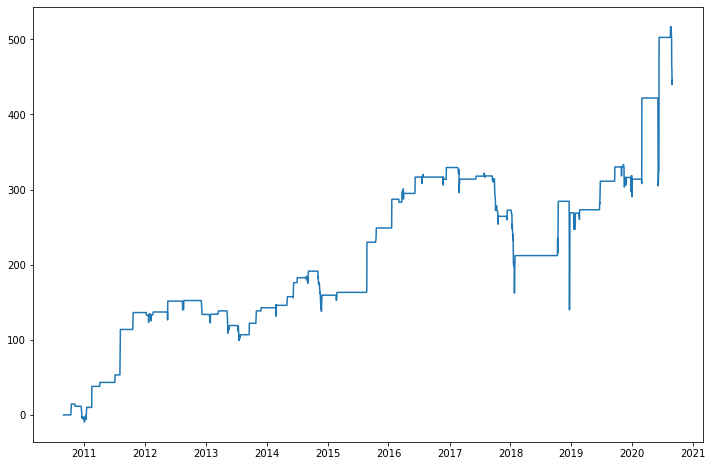

In [40]:
df_ES_1, sharpe_ES_1 = trade_logic(
    market = 'ES',
    params = {'lookback': 14, 'thresh_rsi': 80, 'thresh_so': 80}
)
print("ES_1: ", end = '')
print(pd.Series(df_ES_1['Raw PnL']).sum())
print("sharpe_ES_1: ", end = '')
print(sharpe_ES_1)
print()

plt.figure(figsize=[12,8])
plt.plot(df_ES_1['Raw PnL'].cumsum())
plt.show()

ES_2: 443.6500000000001
sharpe_ES_2: 0.5497971191360445



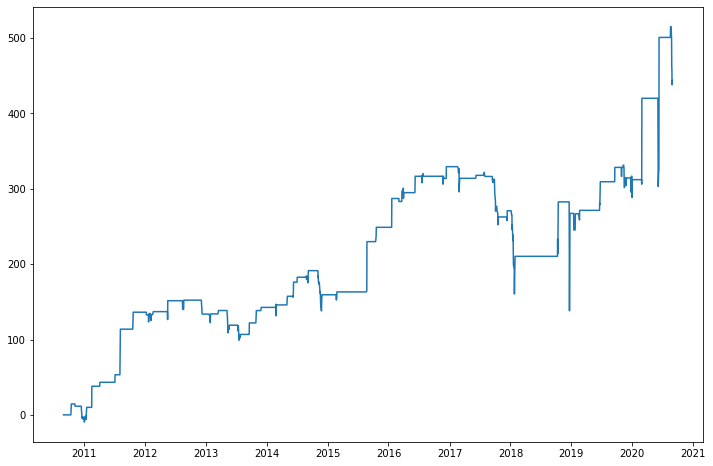

In [56]:
df_ES_2, sharpe_ES_2 = trade_logic(
    market = 'ES',
    params = {'lookback': 14, 'thresh_rsi': 80, 'thresh_so': 80.5}
)
print("ES_2: ", end = '')
print(pd.Series(df_ES_2['Raw PnL']).sum())
print("sharpe_ES_2: ", end = '')
print(sharpe_ES_2)
print()

plt.figure(figsize=[12,8])
plt.plot(df_ES_2['Raw PnL'].cumsum())
plt.show()

ES_3: 416.9000000000001
sharpe_ES_3: 0.5459825321766054



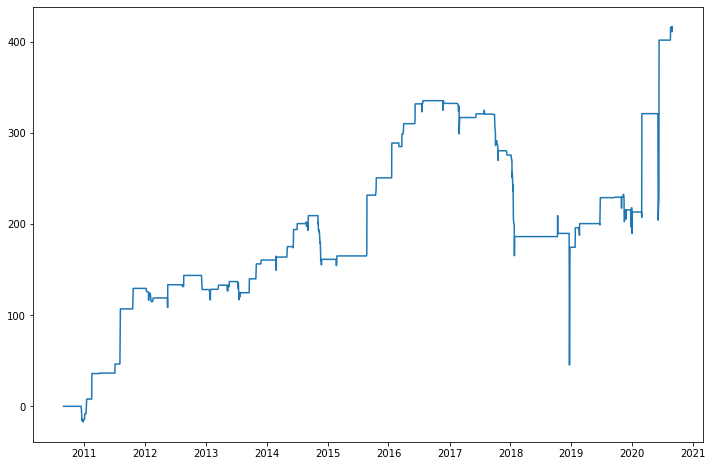

In [49]:
df_ES_3, sharpe_ES_3 = trade_logic(
    market = 'ES',
    params = {'lookback': 14, 'thresh_rsi': 81, 'thresh_so': 82}
)
print("ES_3: ", end = '')
print(pd.Series(df_ES_3['Raw PnL']).sum())
print("sharpe_ES_3: ", end = '')
print(sharpe_ES_3)
print()

plt.figure(figsize=[12,8])
plt.plot(df_ES_3['Raw PnL'].cumsum())
plt.show()

## NQ

NQ_1: 1345.75
sharpe_NQ_1: 0.49953256752705577



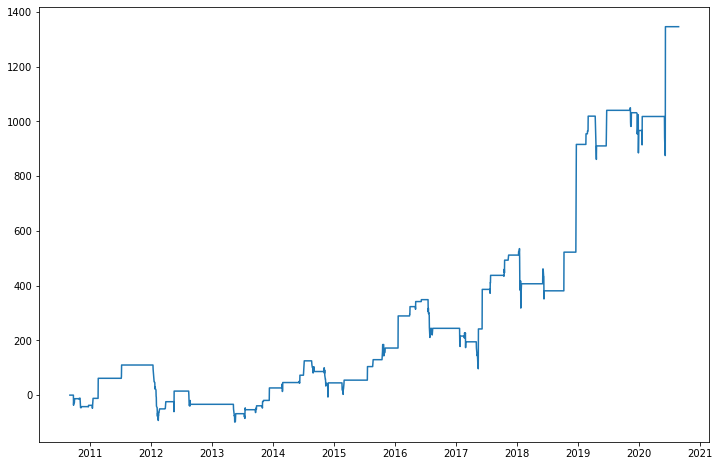

In [57]:
df_NQ_1, sharpe_NQ_1 = trade_logic(
    market = 'NQ',
    params = {'lookback': 14, 'thresh_rsi': 80, 'thresh_so': 80}
)
print("NQ_1: ", end = '')
print(pd.Series(df_NQ_1['Raw PnL']).sum())
print("sharpe_NQ_1: ", end = '')
print(sharpe_NQ_1)
print()

plt.figure(figsize=[12,8])
plt.plot(df_NQ_1['Raw PnL'].cumsum())
plt.show()

NQ_2: 1274.75
sharpe_NQ_2: 0.4931380638558372



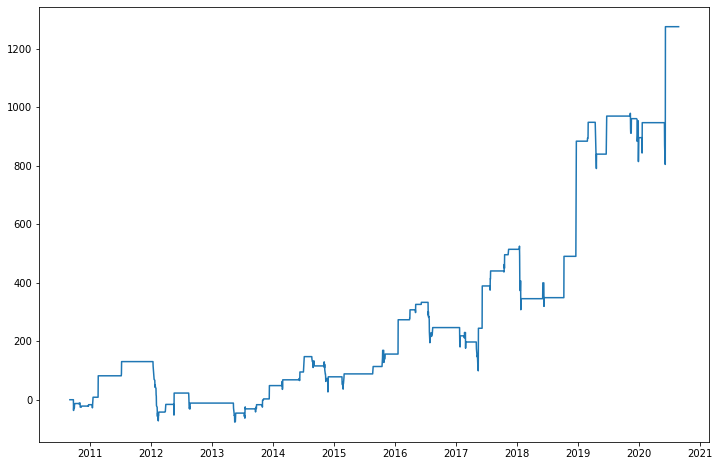

In [58]:
df_NQ_2, sharpe_NQ_2 = trade_logic(
    market = 'NQ',
    params = {'lookback': 14, 'thresh_rsi': 80.5, 'thresh_so': 81}
)
print("NQ_2: ", end = '')
print(pd.Series(df_NQ_2['Raw PnL']).sum())
print("sharpe_NQ_2: ", end = '')
print(sharpe_NQ_2)
print()

plt.figure(figsize=[12,8])
plt.plot(df_NQ_2['Raw PnL'].cumsum())
plt.show()

NQ_3: 1155.25
sharpe_NQ_3: 0.46666415452853277



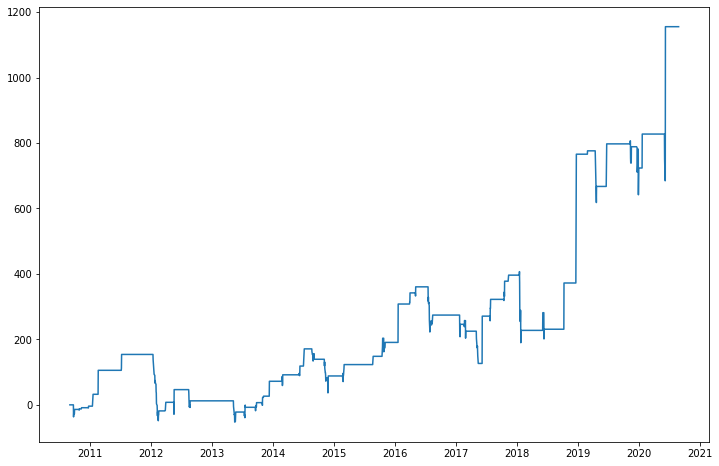

In [59]:
df_NQ_3, sharpe_NQ_3 = trade_logic(
    market = 'NQ',
    params = {'lookback': 14, 'thresh_rsi': 81, 'thresh_so': 82}
)
print("NQ_3: ", end = '')
print(pd.Series(df_NQ_3['Raw PnL']).sum())
print("sharpe_NQ_3: ", end = '')
print(sharpe_NQ_3)
print()

plt.figure(figsize=[12,8])
plt.plot(df_NQ_3['Raw PnL'].cumsum())
plt.show()

## 6E

6E_1: 0.017099999999999227
sharpe_6E_1: 0.06198696134767474



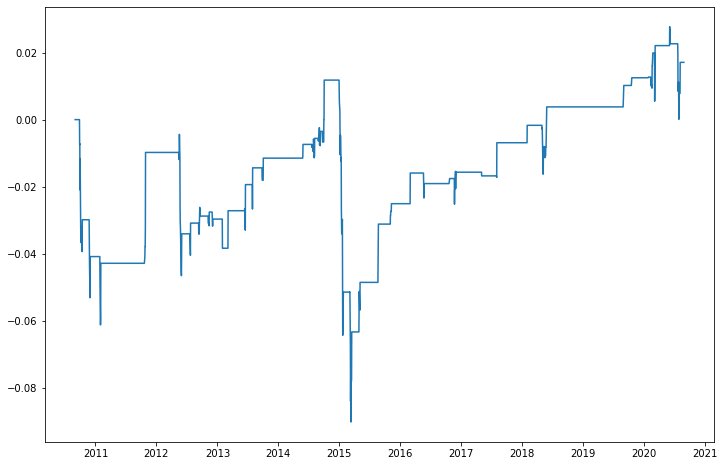

In [60]:
df_6E_1, sharpe_6E_1 = trade_logic(
    market = '6E',
    params = {'lookback': 14, 'thresh_rsi': 80, 'thresh_so': 80}
)
print("6E_1: ", end = '')
print(pd.Series(df_6E_1['Raw PnL']).sum())
print("sharpe_6E_1: ", end = '')
print(sharpe_6E_1)
print()

plt.figure(figsize=[12,8])
plt.plot(df_6E_1['Raw PnL'].cumsum())
plt.show()

6E_2: 0.00789999999999913
sharpe_6E_2: 0.030611995049003412



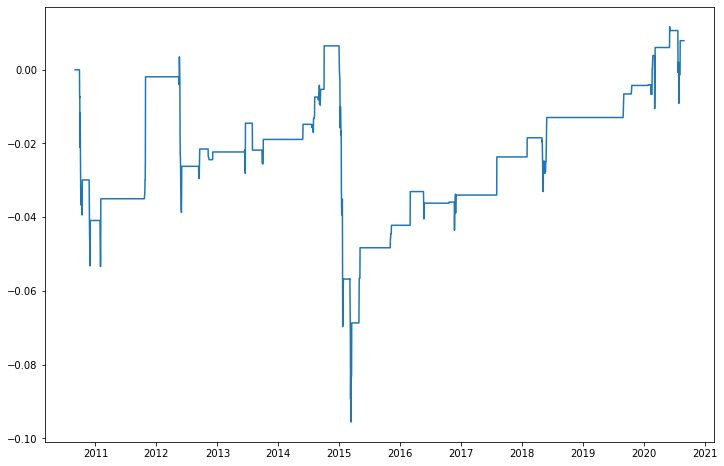

In [61]:
df_6E_2, sharpe_6E_2 = trade_logic(
    market = '6E',
    params = {'lookback': 14, 'thresh_rsi': 80.5, 'thresh_so': 81}
)
print("6E_2: ", end = '')
print(pd.Series(df_6E_2['Raw PnL']).sum())
print("sharpe_6E_2: ", end = '')
print(sharpe_6E_2)
print()

plt.figure(figsize=[12,8])
plt.plot(df_6E_2['Raw PnL'].cumsum())
plt.show()

6E_3: -0.004850000000000687
sharpe_6E_3: -0.009203680077453934



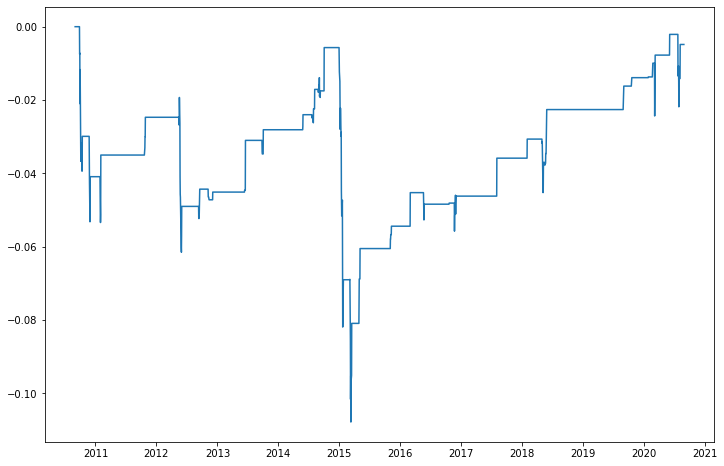

In [62]:
df_6E_3, sharpe_6E_3 = trade_logic(
    market = '6E',
    params = {'lookback': 14, 'thresh_rsi': 81, 'thresh_so': 82}
)
print("6E_3: ", end = '')
print(pd.Series(df_6E_3['Raw PnL']).sum())
print("sharpe_6E_3: ", end = '')
print(sharpe_6E_3)
print()

plt.figure(figsize=[12,8])
plt.plot(df_6E_3['Raw PnL'].cumsum())
plt.show()

## CL

CL_1: 3.2900000000000063
sharpe_CL_1: 0.030881366435938223



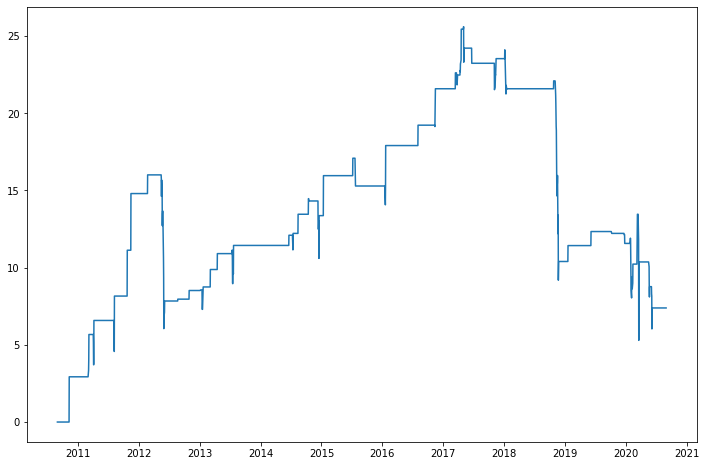

In [68]:
df_CL_1, sharpe_CL_1 = trade_logic(
    market = 'CL',
    params = {'lookback': 14, 'thresh_rsi': 80, 'thresh_so': 80}
)
print("CL_1: ", end = '')
print(pd.Series(df_CL_1['Raw PnL']).sum())
print("sharpe_CL_1: ", end = '')
print(sharpe_CL_1)
print()

plt.figure(figsize=[12,8])
plt.plot(df_CL_3['Raw PnL'].cumsum())
plt.show()

CL_2: 0.2699999999999818
sharpe_CL_2: -0.014559328653135402



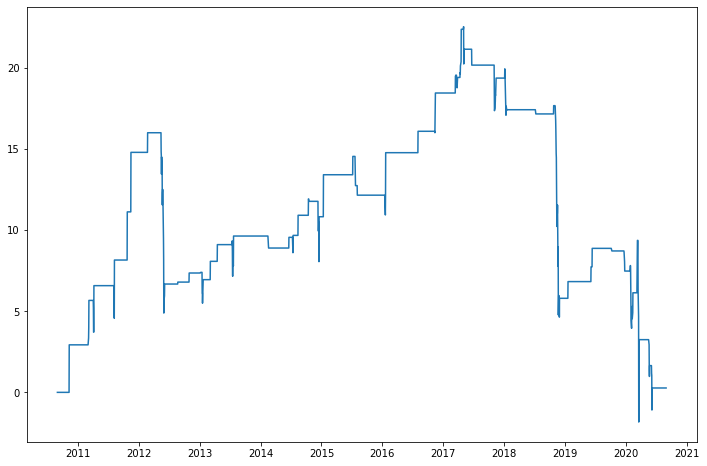

In [75]:
df_CL_2, sharpe_CL_2 = trade_logic(
    market = 'CL',
    params = {'lookback': 14, 'thresh_rsi': 80.5, 'thresh_so': 81}
)
print("CL_2: ", end = '')
print(pd.Series(df_CL_2['Raw PnL']).sum())
print("sharpe_CL_2: ", end = '')
print(sharpe_CL_2)
print()

plt.figure(figsize=[12,8])
plt.plot(df_CL_2['Raw PnL'].cumsum())
plt.show()

CL_3: 7.390000000000008
sharpe_CL_3: 0.08842560575998262



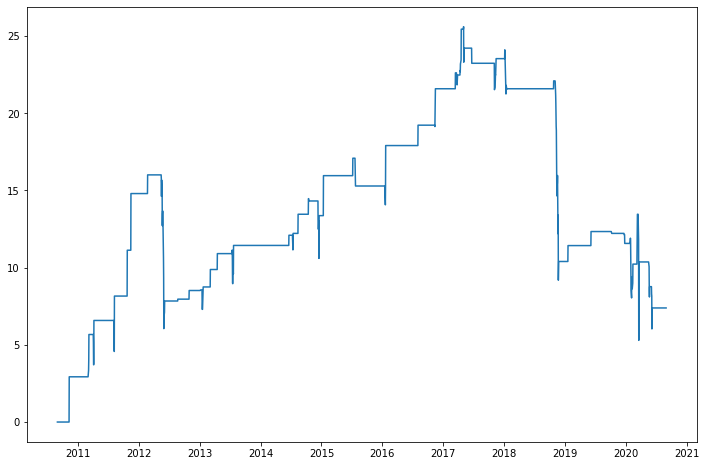

In [66]:
df_CL_3, sharpe_CL_3 = trade_logic(
    market = 'CL',
    params = {'lookback': 14, 'thresh_rsi': 81, 'thresh_so': 82}
)
print("CL_3: ", end = '')
print(pd.Series(df_CL_3['Raw PnL']).sum())
print("sharpe_CL_3: ", end = '')
print(sharpe_CL_3)
print()

plt.figure(figsize=[12,8])
plt.plot(df_CL_3['Raw PnL'].cumsum())
plt.show()

## GC

GC_1: -15.299999999999727
sharpe_GC_1: -0.016467572037454324



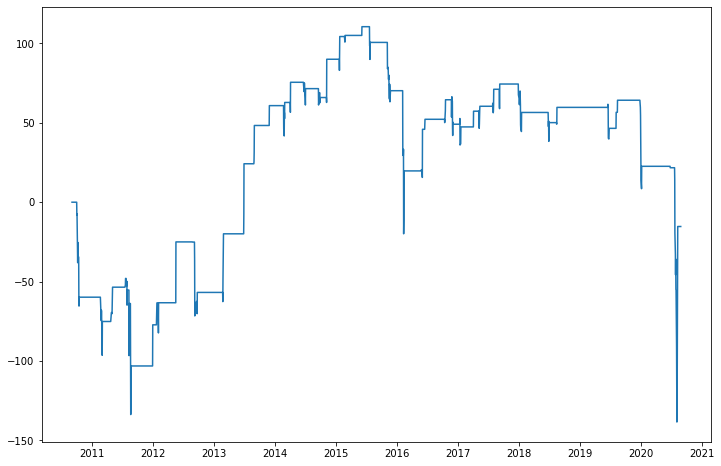

In [69]:
df_GC_1, sharpe_GC_1 = trade_logic(
    market = 'GC',
    params = {'lookback': 14, 'thresh_rsi': 80, 'thresh_so': 80}
)
print("GC_1: ", end = '')
print(pd.Series(df_GC_1['Raw PnL']).sum())
print("sharpe_GC_1: ", end = '')
print(sharpe_GC_1)
print()

plt.figure(figsize=[12,8])
plt.plot(df_GC_1['Raw PnL'].cumsum())
plt.show()

GC_2: -3.699999999999136
sharpe_GC_2: -0.009030368236741759



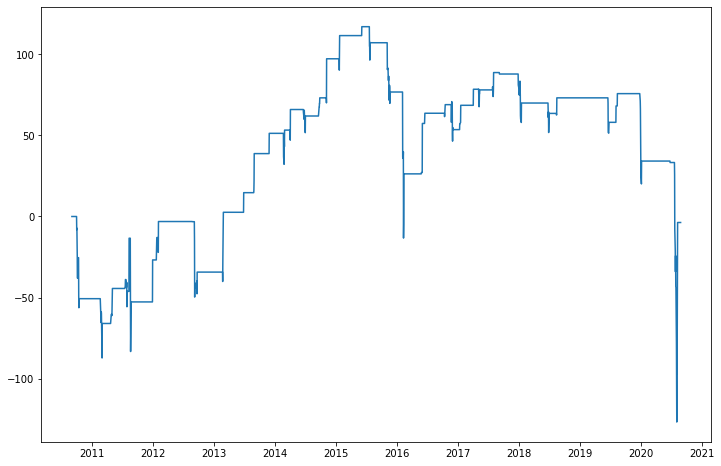

In [70]:
df_GC_2, sharpe_GC_2 = trade_logic(
    market = 'GC',
    params = {'lookback': 14, 'thresh_rsi': 80.5, 'thresh_so': 81}
)
print("GC_2: ", end = '')
print(pd.Series(df_GC_2['Raw PnL']).sum())
print("sharpe_GC_2: ", end = '')
print(sharpe_GC_2)
print()

plt.figure(figsize=[12,8])
plt.plot(df_GC_2['Raw PnL'].cumsum())
plt.show()

GC_3: -1.399999999998954
sharpe_GC_3: 0.00651295778919879



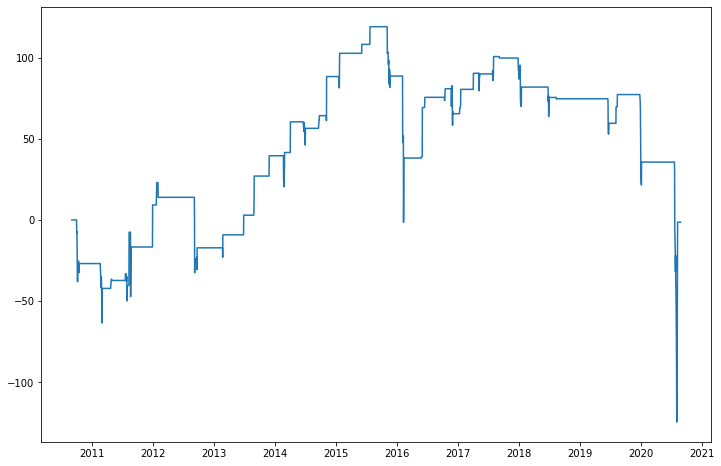

In [71]:
df_GC_3, sharpe_GC_3 = trade_logic(
    market = 'GC',
    params = {'lookback': 14, 'thresh_rsi': 81, 'thresh_so': 82}
)
print("GC_3: ", end = '')
print(pd.Series(df_GC_3['Raw PnL']).sum())
print("sharpe_GC_3: ", end = '')
print(sharpe_GC_3)
print()

plt.figure(figsize=[12,8])
plt.plot(df_GC_3['Raw PnL'].cumsum())
plt.show()

## ZC

ZC_1: 125.5
sharpe_ZC_1: 0.434426057477571



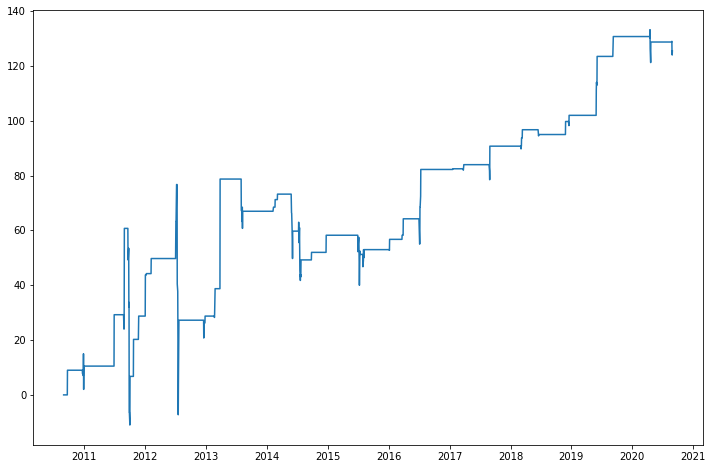

In [72]:
df_ZC_1, sharpe_ZC_1 = trade_logic(
    market = 'ZC',
    params = {'lookback': 14, 'thresh_rsi': 80, 'thresh_so': 80}
)
print("ZC_1: ", end = '')
print(pd.Series(df_ZC_1['Raw PnL']).sum())
print("sharpe_ZC_1: ", end = '')
print(sharpe_ZC_1)
print()

plt.figure(figsize=[12,8])
plt.plot(df_ZC_1['Raw PnL'].cumsum())
plt.show()

ZC_3: 78.0
sharpe_ZC_3: 0.3319114130238255



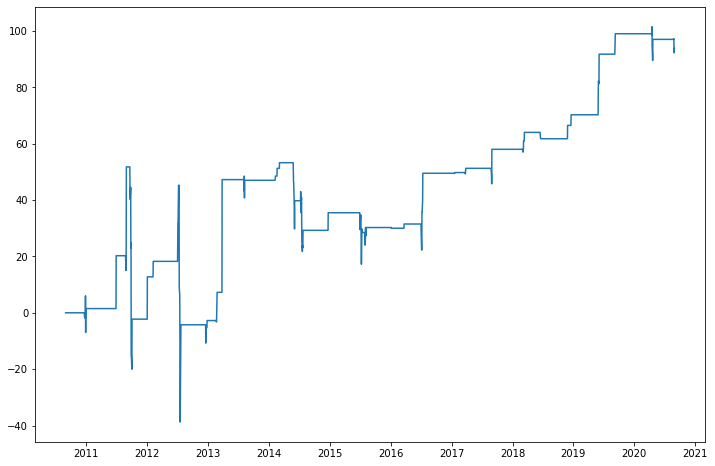

In [73]:
df_ZC_3, sharpe_ZC_3 = trade_logic(
    market = 'ZC',
    params = {'lookback': 14, 'thresh_rsi': 81, 'thresh_so': 82}
)
print("ZC_3: ", end = '')
print(pd.Series(df_ZC_3['Raw PnL']).sum())
print("sharpe_ZC_3: ", end = '')
print(sharpe_ZC_3)
print()

plt.figure(figsize=[12,8])
plt.plot(df_ZC_2['Raw PnL'].cumsum())
plt.show()

ZC_2: 93.75
sharpe_ZC_2: 0.3367678088572381



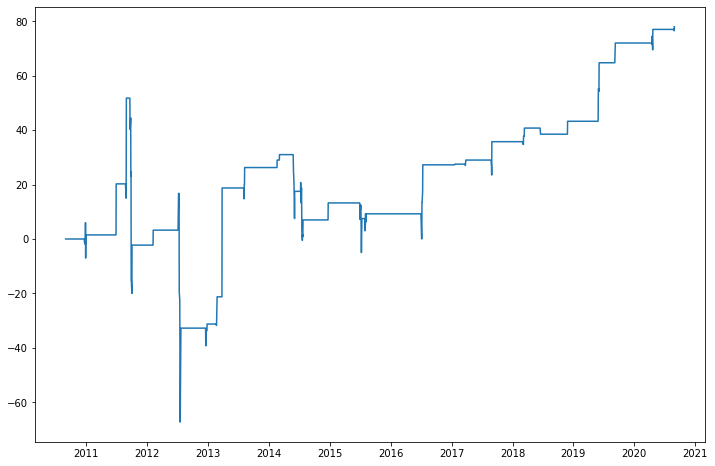

In [74]:
df_ZC_2, sharpe_ZC_2 = trade_logic(
    market = 'ZC',
    params = {'lookback': 14, 'thresh_rsi': 80.5, 'thresh_so': 81}
)
print("ZC_2: ", end = '')
print(pd.Series(df_ZC_2['Raw PnL']).sum())
print("sharpe_ZC_2: ", end = '')
print(sharpe_ZC_2)
print()

plt.figure(figsize=[12,8])
plt.plot(df_ZC_3['Raw PnL'].cumsum())
plt.show()